# ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# データの読み込み

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


# 簡単なデータの確認

In [4]:
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(f'(index, col) : {df.shape}')
    return info_df

information_df(train_df)

(index, col) : (165034, 14)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,165034,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
CustomerId,int64,0,23221,"[15674932, 15749177, 15694510, 15741417, 15766..."
Surname,object,0,2797,"[Okwudilichukwu, Okwudiliolisa, Hsueh, Kao, Ch..."
CreditScore,int64,0,457,"[668, 627, 678, 581, 716, 588, 593, 676, 583, ..."
Geography,object,0,3,"[France, Spain, Germany]"
Gender,object,0,2,"[Male, Female]"
Age,float64,0,71,"[33.0, 40.0, 34.0, 36.0, 30.0, 37.0, 43.0, 27...."
Tenure,int64,0,11,"[3, 1, 10, 2, 5, 4, 8, 6, 9, 7, 0]"
Balance,float64,0,30075,"[0.0, 148882.54, 131778.58, 144772.69, 138476...."
NumOfProducts,int64,0,4,"[2, 1, 3, 4]"


In [5]:
information_df(test_df)

(index, col) : (110023, 13)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,110023,"[165034, 165035, 165036, 165037, 165038, 16503..."
CustomerId,int64,0,19698,"[15773898, 15782418, 15807120, 15808905, 15607..."
Surname,object,0,2708,"[Lucchese, Nott, K?, O'Donnell, Higgins, Pears..."
CreditScore,int64,0,454,"[586, 683, 656, 681, 752, 593, 682, 539, 845, ..."
Geography,object,0,3,"[France, Germany, Spain]"
Gender,object,0,2,"[Female, Male]"
Age,float64,0,74,"[23.0, 46.0, 34.0, 36.0, 38.0, 22.0, 45.0, 47...."
Tenure,int64,0,11,"[2, 7, 8, 10, 9, 4, 3, 5, 1, 6, 0]"
Balance,float64,0,22513,"[0.0, 121263.62, 111096.91, 130878.75, 135070...."
NumOfProducts,int64,0,4,"[2, 1, 4, 3]"


＜考察＞
* trainとtestともに欠損値はなし
* データ数 train:test = 165034:110023（約3/4）
* データ型が大きい ➡️　データのメモリを削減する

In [6]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [7]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 17.63 MB
Memory usage after optimization is: 4.96 MB
Decreased by 71.8%
Memory usage of dataframe is 10.91 MB
Memory usage after optimization is: 3.23 MB
Decreased by 70.4%


In [8]:
features = ['Age', 'NumOfProducts', 'IsActiveMember']
x_train = train_df[features]
y_train = train_df['Exited']

In [9]:
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.2,
    stratify=y_train,
    random_state=123
)

print(x_tr.shape)  # 特徴量の形状を確認
print(y_tr.shape)  # ターゲットの形状を確認

(132027, 3)
(132027,)


In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'random_state': 123,
    'num_leaves': 16,
    'n_estimators': 10000,
    'importance_type': 'gain',
    'verbose': 1
}

In [11]:
model = lgb.LGBMClassifier(**params)
model.fit(
    x_tr, y_tr,
    eval_set= [(x_tr, y_tr), (x_va, y_va)],
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=100),
        lgb.callback.log_evaluation(period=100)
    ]
)

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.867994	valid_1's auc: 0.862127
[200]	training's auc: 0.868242	valid_1's auc: 0.861998
Early stopping, best iteration is:
[101]	training's auc: 0.868006	valid_1's auc: 0.862141


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=10000,
               num_leaves=16, objective='binary', random_state=123, verbose=1)

In [12]:
y_tr_pred = model.predict_proba(x_tr)[:, 1]
y_va_pred = model.predict_proba(x_va)[:, 1]

metric_tr = roc_auc_score(y_tr, y_tr_pred)
metric_va = roc_auc_score(y_va, y_va_pred)

print("Tr:", metric_tr)
print("Va:", metric_va)

Tr: 0.8680063236926455
Va: 0.8621405390394143


In [13]:
imp = pd.DataFrame({
    'col': x_train.columns,
    'imp': model.feature_importances_
})

imp.sort_values('imp', ascending=True)

,col,imp
2,IsActiveMember,26308.015236
1,NumOfProducts,97482.994096
0,Age,114812.921993


In [14]:
metric=[]
imp=pd.DataFrame()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
    print('-'*20, nfold, '-'*20)
    x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
    x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        x_tr, y_tr,
        eval_set= [(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )
    
    y_tr_pred = model.predict_proba(x_tr)[:, 1]
    y_va_pred = model.predict_proba(x_va)[:, 1]
    
    metric_tr = roc_auc_score(y_tr, y_tr_pred)
    metric_va = roc_auc_score(y_va, y_va_pred)

    metric.append((nfold, metric_tr, metric_va))
    
    print("Tr:", metric_tr)
    print("Va:", metric_va)
    
    _imp = pd.DataFrame({
        'col': x_train.columns,
        'imp': model.feature_importances_,
        'fold': nfold
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*50)
print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
print('-'*50)

metric = np.array(metric)
print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()))
print('[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

-------------------- 0 --------------------
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.867302	valid_1's auc: 0.864693
Early stopping, best iteration is:
[63]	training's auc: 0.86706	valid_1's auc: 0.864798
Tr: 0.867059713252888
Va: 0.8647977536965162
-------------------- 1 --------------------
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing r

In [15]:
imp_df = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp_df.columns = ['imp', 'imp_std']
imp_df.reset_index(drop=False)
imp_df

,imp,imp_std
col,,
Age,113797.770278,729.014039
IsActiveMember,26159.480937,151.474828
NumOfProducts,96645.919726,458.723590


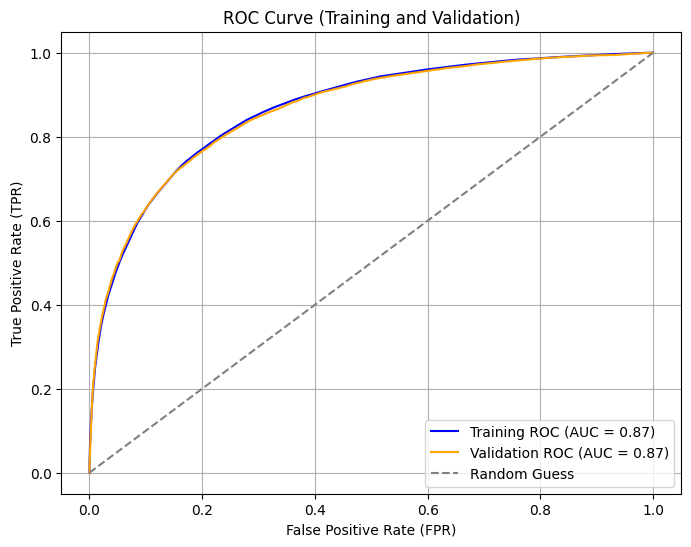

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

y_tr_score = model.predict_proba(x_tr)[:, 1]
y_va_score = model.predict_proba(x_va)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_tr_score)
auc_tr = roc_auc_score(y_tr, y_tr_score)

fpr_va, tpr_va, _ = roc_curve(y_va, y_va_score)
auc_va = roc_auc_score(y_va, y_va_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tr, tpr_tr, label=f'Training ROC (AUC = {auc_tr:.2f})', color='blue')
plt.plot(fpr_va, tpr_va, label=f'Validation ROC (AUC = {auc_va:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Training and Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [17]:
y_pred_prob = model.predict_proba(test_df[features])[:, 1]  


sub = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
test_ids = sub['id'] 

submission = pd.DataFrame({
    'id': test_ids,
    'Exited': y_pred_prob
})

# 提出データの名前を手動で設定（.csv拡張子は不要）
submission_name = "example_submission"

submission.to_csv(f'{submission_name}.csv', index=False)
submission.head()

,id,Exited
0,165034,0.021536
1,165035,0.730051
2,165036,0.028202
3,165037,0.299012
4,165038,0.317886


In [18]:
import os

# ノートブック全体を保存
notebook_name = submission_name  # 任意の名前（.ipynb拡張子は不要）
!jupyter nbconvert --to notebook --output {notebook_name}.ipynb --inplace

# GitHub用の設定
repository_name = "Binary-Classification-with-a-Bank-Churn-Dataset"  # GitHubリポジトリ名
your_username = "skyshine460"
# github_token = "your_github_token"        # GitHubアクセストークン
github_url = f"https://github.com/{your_username}/{repository_name}.git"

# GitHubリポジトリをクローン
if not os.path.exists(repository_name):
    !git clone {github_url}

# ノートブックをリポジトリにコピー
!cp {notebook_name}.ipynb {repository_name}/

# Git操作
%cd {repository_name}
!git add {notebook_name}.ipynb
!git commit -m "Add notebook for submission"
!git push origin main

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr